In [1]:
import pandas as pd
import glob
import numpy as np
from datetime import timedelta


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.compose import ColumnTransformer
#from xgboost import XGBClassifier

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_path = "D:/unified_metor_content/fraud_detection/fraud_detection/" 

file_list = sorted(glob.glob(data_path + "*.pkl"))

# Read and concatenate all daily files
df_all = pd.concat([pd.read_pickle(file) for file in file_list], ignore_index=True)

In [5]:
df_all["fraud_amt"] = (df_all["TX_AMOUNT"] > 220).astype(int)

In [6]:
fraud_counts= df_all[df_all['TX_FRAUD'] == 1].groupby('TERMINAL_ID').size()
df_all['fraud_count'] = df_all['TERMINAL_ID'].map(fraud_counts).fillna(0).astype(int)


In [7]:
log_vals_frdcount = np.log10(df_all['fraud_count']+0.001)
log_vals_frdcount.skew()
df_all['log_vals_frdcount'] = np.log10(df_all['fraud_count']+0.001)

In [8]:
np.random.seed(42)

# Parse datetime
df_all['datetime'] = pd.to_datetime(df_all['TX_DATETIME'])

# Sort by time
df_all = df_all.sort_values('TX_DATETIME').reset_index(drop=True)

# Create helper columns if not present
if 'TX_FRAUD' not in df_all.columns:
    df_all['TX_FRAUD'] = 0
if 'TX_FRAUD_SCENARIO' not in df_all.columns:
    df_all['TX_FRAUD_SCENARIO'] = 0

# Add date column
df_all['date'] = df_all['datetime'].dt.date
df_all['date'] = df_all['datetime'].dt.floor('D')
# Get all unique transaction dates
unique_dates = df_all['date'].unique()

# Simulate fraud
for day in unique_dates[:-14]:
    current_day = pd.to_datetime(day)
    window_end = current_day + timedelta(days=14)

    active_customers = df_all[df_all['date'] == day]['CUSTOMER_ID'].unique()

    if len(active_customers) < 3:
        continue

    selected_customers = np.random.choice(active_customers, size=3, replace=False)

    for cust_id in selected_customers:
        mask = (
            (df_all['CUSTOMER_ID'] == cust_id) &
            (df_all['datetime'] > current_day) &
            (df_all['datetime'] <= window_end)
        )
        cust_txns = df_all[mask]

        if len(cust_txns) == 0:
            continue

        num_fraud = max(1, len(cust_txns) // 3)
        fraud_indices = cust_txns.sample(n=num_fraud, random_state=42).index

        df_all.loc[fraud_indices, 'TX_AMOUNT'] *= 5
        df_all.loc[fraud_indices, 'TX_FRAUD'] = 1
        df_all.loc[fraud_indices, 'TX_FRAUD_SCENARIO'] = 4

In [9]:
df_all['datetime'] = pd.to_datetime(df_all['TX_DATETIME'])

In [10]:
df_all['avg_tx_amt_14d'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean().fillna(method='ffill')
          .fillna(0)
)

In [11]:
df_all['std_tx_amt_14d'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(
    lambda x: x.rolling(window=14, min_periods=1).std().fillna(method='ffill')
          .fillna(0)
)


In [12]:
log_vals = np.log1p(df_all['std_tx_amt_14d'])
df_all['log_vals_std'] = np.log1p(df_all['std_tx_amt_14d'])
log_vals.skew()

-0.6234364098264098

In [13]:
df_all.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
 9   fraud_amt          int32         
 10  fraud_count        int32         
 11  log_vals_frdcount  float64       
 12  datetime           datetime64[ns]
 13  date               datetime64[ns]
 14  avg_tx_amt_14d     float64       
 15  std_tx_amt_14d     float64       
 16  log_vals_std       float64       
dtypes: datetime64[ns](3), float64(5), int32(2), int64(3), object(4)
memory usage: 214.1+ MB


In [14]:
df_all['unique_terminals_28d'] = (
    df_all.sort_values(['CUSTOMER_ID', 'datetime'])
         .groupby('CUSTOMER_ID')
         .rolling('28D', on='datetime')['TERMINAL_ID']
         .apply(lambda x: x.nunique(), raw=False)
         .reset_index(level=0, drop=True)
         .reset_index(drop=True)
)


df_all['unique_terminals_28d'] = df_all['unique_terminals_28d'].fillna(0)


In [15]:
df_all['unique_terminals_28d'].skew()

-0.6683984339086946

In [16]:
 df_all['is_new_terminal'] = (
    df_all.groupby('CUSTOMER_ID')['TERMINAL_ID']
         .transform(lambda x: ~x.duplicated())
).astype(int)


In [17]:
df_all['is_new_terminal'].skew()

1.574778708413574

In [18]:
df_all['amount_mean'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')
df_all['amount_std'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('std')
df_all['amount_zscore'] = (
   (df_all['TX_AMOUNT'] - df_all['amount_mean']) / df_all['amount_std']
).fillna(0)


In [19]:
sqrt_zscore = np.sqrt(df_all['amount_zscore'])
df_all['sqrt_zscore'] = np.sqrt(df_all['amount_zscore'])
sqrt_zscore.skew()

C:\Users\5520\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.6879062335637943

In [20]:
df_all['amount_ratio'] = (
    df_all['TX_AMOUNT'] / df_all['amount_mean']
).fillna(1)


In [21]:
df_all['amount_ratio'].skew()

3.804955442660139

In [22]:
sqrt_ratio = np.sqrt(df_all['amount_ratio'])
df_all['sqrt_ratio'] = np.sqrt(df_all['amount_ratio'])

sqrt_ratio.skew()

0.1413734202472882

In [23]:
df_all['is_weekend'] = df_all['datetime'].dt.weekday >= 5  # Saturday=5, Sunday=6
df_all['is_weekend'] = df_all['is_weekend'].astype(int)

In [24]:
df_all['is_weekend'].skew()

0.9265724265354897

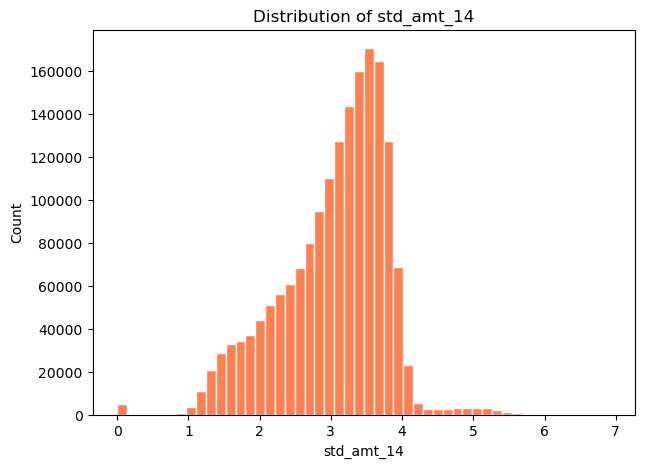

In [25]:
# Plotting the histogram of std_amt_14
log_vals = np.log1p(df_all['std_tx_amt_14d'])
plt.figure(figsize=(7, 5))
plt.hist(log_vals, bins=50, color='#ff7f50', edgecolor='white')
plt.title('Distribution of std_amt_14')
plt.xlabel('std_amt_14')
plt.ylabel('Count')
plt.show()

In [26]:
log_vals.skew()

-0.6234364098264098

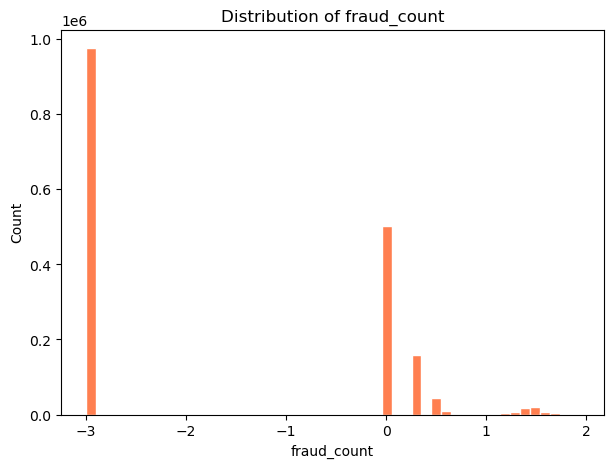

In [27]:
log_vals_fraud_count = np.log10(df_all['fraud_count']+0.001) 
#sqrt_vals = np.power(X['fraud_count'],4)
#from sklearn.preprocessing import PowerTransformer

#transformer = PowerTransformer(method='yeo-johnson')
#yeo_vals = transformer.fit_transform(X[['fraud_count']])

plt.figure(figsize=(7, 5))
plt.hist(log_vals_fraud_count, bins=50, color='#ff7f50', edgecolor='white')
plt.title('Distribution of fraud_count')
plt.xlabel('fraud_count')
plt.ylabel('Count')
plt.show()

In [28]:
log_vals_fraud_count.skew()

0.32077679292218464

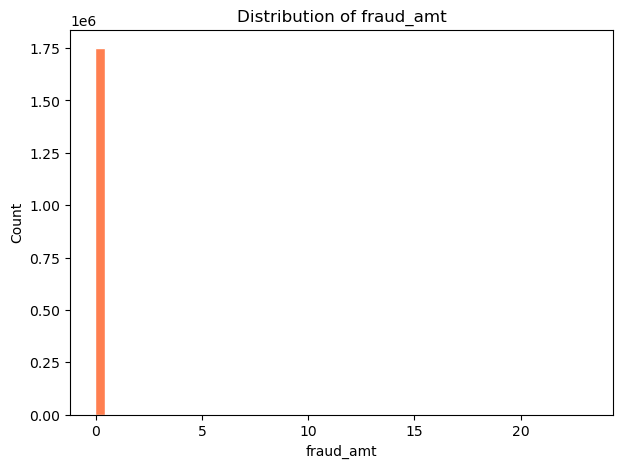

In [29]:
#log_vals_fraud_amt = np.log10(X['fraud_amt']+0.001)
#log_vals_fraud_amt = np.sqrt(X['fraud_amt'])
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')
log_vals_fraud_amt = transformer.fit_transform(df_all[['fraud_amt']])
plt.figure(figsize=(7, 5))
plt.hist(log_vals_fraud_amt, bins=50, color='#ff7f50', edgecolor='white')
plt.title('Distribution of fraud_amt')
plt.xlabel('fraud_amt')
plt.ylabel('Count')
plt.show()

In [30]:
#log_vals_fraud_amt.skew()

In [31]:
df_all.drop(columns=['amount_mean', 'amount_std'], inplace=True) 

In [32]:
from sklearn.model_selection import train_test_split

df = df_all.drop(columns = ['TX_DATETIME','datetime','date','TX_FRAUD_SCENARIO','TX_TIME_SECONDS','TX_TIME_DAYS'])

#df['TX_TIME_SECONDS'] = pd.to_numeric(df['TX_TIME_SECONDS'], errors='coerce')
#df['TX_TIME_DAYS'] = pd.to_numeric(df['TX_TIME_DAYS'], errors='coerce')
df['CUSTOMER_ID'] = pd.to_numeric(df['CUSTOMER_ID'], errors='coerce')
df['TERMINAL_ID'] = pd.to_numeric(df['TERMINAL_ID'], errors='coerce')
# Define your split point (e.g., 70% of the data for training)




In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   TRANSACTION_ID        int64  
 1   CUSTOMER_ID           int64  
 2   TERMINAL_ID           int64  
 3   TX_AMOUNT             float64
 4   TX_FRAUD              int64  
 5   fraud_amt             int32  
 6   fraud_count           int32  
 7   log_vals_frdcount     float64
 8   avg_tx_amt_14d        float64
 9   std_tx_amt_14d        float64
 10  log_vals_std          float64
 11  unique_terminals_28d  float64
 12  is_new_terminal       int32  
 13  amount_zscore         float64
 14  sqrt_zscore           float64
 15  amount_ratio          float64
 16  sqrt_ratio            float64
 17  is_weekend            int32  
dtypes: float64(10), int32(4), int64(4)
memory usage: 214.1 MB


In [34]:
X = df.drop(columns = ['TX_FRAUD'])
y = df['TX_FRAUD']


# First split into training and temporary set
X_normal = X[y == 0]  # only non-fraud transactions
X_fraud = X[y == 1]  # fraud transactions (anomalous)

# Step 1: Create normal-only training set
X_train, X_cv_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

# Step 2: Add frauds to validation set
X_cv = pd.concat([X_cv_normal, X_fraud], axis=0)
y_cv = pd.Series([0]*len(X_cv_normal) + [1]*len(X_fraud), index=X_cv.index)
# Test will be a mixture of normal and fraud
X_test, y_test = X.loc[X.index.difference(X_cv.index)], y.loc[X.index.difference(X_cv.index)]

print("Training set (normal only):", X_train.shape)
print("Validation set (normal + fraud):", X_cv.shape, y_cv.value_counts()) 
print("Test set (normal + fraud):", X_test.shape, y_test.value_counts()) 


Training set (normal only): (1387361, 17)
Validation set (normal + fraud): (366794, 17) 0    346841
1     19953
Name: count, dtype: int64
Test set (normal + fraud): (1387361, 17) TX_FRAUD
0    1387361
Name: count, dtype: int64


In [35]:
num_features =['TX_AMOUNT','fraud_amt','fraud_count','log_vals_frdcount','avg_tx_amt_14d','std_tx_amt_14d','log_vals_std','sqrt_zscore','sqrt_ratio']

In [36]:
from sklearn.preprocessing import StandardScaler
categorical = [col for col in X.columns if col not in num_features]
# Then fit scaler on training only
scaler = StandardScaler()
scaler.fit(X_train[num_features])

# Transform both
X_train_scaled = scaler.transform(X_train[num_features])
X_cv_scaled = scaler.transform(X_cv[num_features])
X_test_scaled = scaler.transform(X_test[num_features])

X_train = np.hstack([X_train_scaled, X_train[categorical].values]) #X_train[categorical].values] df converted into numpy array
X_cv = np.hstack([X_cv_scaled, X_cv[categorical].values])
X_test = np.hstack([X_test_scaled, X_test[categorical].values])

In [37]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
model.fit(X_train)


IsolationForest(random_state=42)

In [38]:
y_pred_cv = model.predict(X_cv)  # -1 for anomaly, 1 for normal
y_pred_test = model.predict(X_test)


In [39]:
y_pred_cv = [1 if x == -1 else 0 for x in y_pred_cv]
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]


In [40]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

print("Validation AUC :", roc_auc_score(y_cv, y_pred_cv))
print("Validation F1 :", f1_score(y_cv, y_pred_cv))
print("Validation confusion_matrix :", confusion_matrix(y_cv, y_pred_cv))
print("Classification Report:\n", classification_report(y_cv, y_pred_cv))


Validation AUC : 0.8749794707035962
Validation F1 : 0.3320205377051421
Validation confusion_matrix : [[269173  77668]
 [   521  19432]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87    346841
           1       0.20      0.97      0.33     19953

    accuracy                           0.79    366794
   macro avg       0.60      0.87      0.60    366794
weighted avg       0.95      0.79      0.84    366794

